In [10]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
# import pandas_datareader.yahoo.daily as yahoo
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Statistical Models
# import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Error Metrics
from sklearn.metrics import mean_squared_error

#Plotting
from pandas.plotting import scatter_matrix
# from statsmodels.graphics.tsaplots import plot_acf

# Plotly
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


In [11]:
#Disable the warnings
import warnings
warnings.filterwarnings('ignore')


# Loading the Data

In [12]:
import yfinance as yf
from datetime import datetime, timedelta
from pandas_datareader.fred import FredReader

# get data for the past year
day = datetime(2022, 12, 31)
start = day - timedelta(days=365.3*10)
end = day

In [13]:
stk_data = yf.download(
    tickers="MSFT IBM GOOGL",
    start=start,
    end=end,
)

[*********************100%***********************]  3 of 3 completed


In [14]:
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

ccy_data = FredReader(
    symbols=ccy_tickers, 
    start=start, 
    end=end,
    )
idx_data = FredReader(
    symbols=idx_tickers, 
    start=start, 
    end=end,
    )

In [15]:
return_period = 5

In [16]:
Y = np.log(stk_data.loc[:, 'Adj Close']['MSFT']).diff(
    return_period).shift(-return_period)
Y.name = Y.name +'_pred'

In [17]:
X1 = stk_data.loc[:, 'Adj Close']
X1.drop(columns=['MSFT'], inplace=True)
X1 = np.log(X1).diff(return_period)
X1.columns = X1.columns


In [18]:
ccy_data = ccy_data.read()
idx_data = idx_data.read()


In [19]:
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)


In [20]:
X4 = pd.concat([np.log(stk_data.loc[:, 'Adj Close']['MSFT']) .diff(i) for i in [
               return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']


In [21]:
X = pd.concat([X1, X2, X3, X4], axis=1)

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]


# Evaluasi Algoritma dan Models

### Train Test Split dan Metrics Evaluation

In [22]:
msft_pred = np.array(Y).reshape(-1,1) # variabel msft_pred

validation_size = 0.2

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]


In [23]:
num_folds = 10
seed = 7

scoring = 'neg_mean_squared_error'

In [24]:
models = []

# Ensemble Method

# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))

models.append(('SVR', SVR()))
# models.append(('MLP', MLPRegressor()))
# Ensemble methods using VotingRegressor
models.append(('VR', VotingRegressor([('ABR', AdaBoostRegressor()), ('GBR', GradientBoostingRegressor()), ('RFR', RandomForestRegressor()), ('SVR', SVR())])))

In [25]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)

    ## K Fold analysis:

    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    #converted mean square error to positive. The lower the beter
    cv_results = -1 * \
        cross_val_score(model, X_train, Y_train, cv=kfold, scoring='neg_mean_absolute_percentage_error')
    kfold_results.append(cv_results)

    # Full Training period
    res = model.fit(X_train, Y_train)

    # print(res.predict(X_train))
    train_predict = res.predict(X_train)
    train_result = mean_squared_error(Y_train, res.predict(X_train))
    train_results.append(train_result)

    # Test results
    # print(res.predict(X_test))
    test_predict = res.predict(X_test)
    test_result = mean_squared_error(Y_test, res.predict(X_test))
    test_results.append(test_result)

    # # Plot Visualisasi Arima
    # # Using nan to fill column
    # trainPredictPlot = np.empty_like(msft_pred)
    # trainPredictPlot[:, :] = np.nan
    # trainPredictPlot[0:len(train_predict), :] = np.array(train_predict).reshape(-1, 1)
    # # print("Train predicted data: ", trainPredictPlot.shape)

    # # Shift test predictions for plotting
    # testPredictPlot = np.empty_like(msft_pred)
    # testPredictPlot[:, :] = np.nan
    # testPredictPlot[len(train_predict):len(msft_pred), :] = np.array(test_predict).reshape(-1, 1)
    # # print("Test predicted data: ", testPredictPlot.shape)

    # date_column = Y.index.to_pydatetime()

    # nama = cycle(['Original Stock Return', 'Prediksi Training', 'Prediksi Testing'])
    # plotdf = pd.DataFrame({'date': date_column, 'original': Y, 'train_predicted':trainPredictPlot.reshape(1, -1)[0].tolist(), 'test_predicted': testPredictPlot.reshape(1, -1)[0].tolist()})
    # # Visualize using plotly
    # fig = px.line(plotdf, x=plotdf['date'], y=[plotdf['original'], plotdf['train_predicted'], plotdf['test_predicted']], labels={'value':'Stock Return(%)', 'date':'Date'})
    # fig.update_layout(title_text=f'Perbandingan Prediksi Stock Return pada {name}', plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
    # fig.for_each_trace(lambda t: t.update(name = next(nama)))

    # fig.update_xaxes(showgrid=False)
    # fig.update_yaxes(showgrid=False)
    # fig.show()

    # msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(),
    #                              cv_results.std(), train_result, test_result)

    msg = "%s: %f" % (name, cv_results.mean())
    print(msg)


ABR: 223081067200.655609
GBR: 496439848268.571167
RFR: 259792622736.560730
SVR: 484465381963.956909
VR: 116157484135.059357


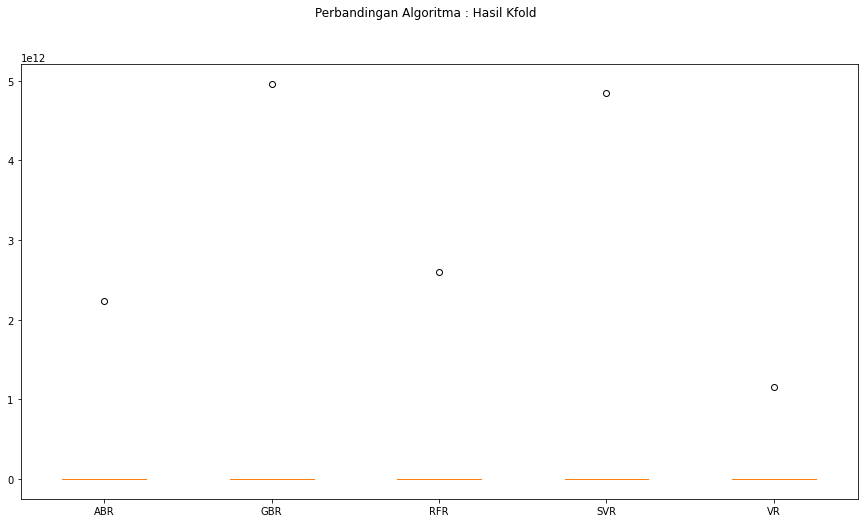

In [26]:
fig = pyplot.figure()
fig.suptitle('Perbandingan Algoritma : Hasil Kfold')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15, 8)
pyplot.show()


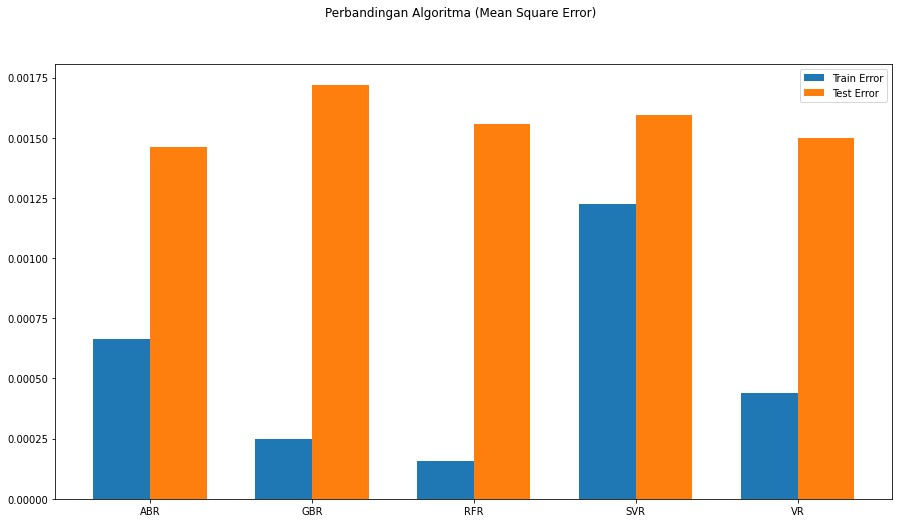

In [27]:
# Perbandingan algoritma
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Perbandingan Algoritma (Mean Square Error)')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15, 8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()